In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd=320):
        super().__init__()
        self.linear_1 = nn.Linear(1, n_embd)
        self.linear_2 = nn.Linear(n_embd, n_embd)

    def forward(self, t):
        x = self.linear_1(t)
        x = F.silu(x)
        x = self.linear_2(x)
        return x

In [4]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=320):
        super().__init__()
        num_groups_feature = min(in_channels, 32)
        num_groups_merged = min(out_channels, 32)

        self.groupnorm_feature = nn.GroupNorm(num_groups_feature, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)
        self.groupnorm_merged = nn.GroupNorm(num_groups_merged, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.residual_layer = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, feature, time):
        residue = feature
        x = F.silu(self.groupnorm_feature(feature))
        x = self.conv_feature(x)
        time = F.silu(time)
        time = self.linear_time(time).unsqueeze(-1).unsqueeze(-1)
        merged = x + time
        merged = F.silu(self.groupnorm_merged(merged))
        merged = self.conv_merged(merged)
        return merged + self.residual_layer(residue)

In [5]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

In [6]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=3): # Default to 3 for RGB images
        super().__init__()
        self.enc1 = UNET_ResidualBlock(in_channels, 128)
        self.enc2 = UNET_ResidualBlock(128, 256)

        # Bottleneck:
        self.bottleneck = UNET_ResidualBlock(256, 256)

        # Decoding
        self.dec1 = UNET_ResidualBlock(256, 128)
        self.dec2 = UNET_ResidualBlock(128, out_channels)

    def forward(self, x, time_emb):
        x = self.enc1(x, time_emb)
        x = self.enc2(x, time_emb)
        x = self.bottleneck(x, time_emb)
        x = self.dec1(x, time_emb)
        x = self.dec2(x, time_emb)
        return x

In [7]:
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        num_groups = max(1, min(32, in_channels))
        self.groupnorm = nn.GroupNorm(num_groups, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.silu(self.groupnorm(x))
        x = self.conv(x)
        return x

In [8]:
class Diffusion(nn.Module):
    def __init__(self, in_channels=3, unet_output_channels=3):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET(in_channels=in_channels, out_channels=unet_output_channels)
        self.final = UNET_OutputLayer(unet_output_channels, unet_output_channels)

    def forward(self, latent, time):
        time = self.time_embedding(time)
        x = self.unet(latent, time)
        x = self.final(x)# final predicted noise
        return x

In [36]:
# Below in code i want to generate the original image of the dog so i have not used this bcoz it starts from random noise so i need to train so that model accurately remove noise and generate realistic image
def reverse_diffusion(diffusion_model, scheduler, shape, device):
    B, C, H, W = shape
    x_t = torch.randn(shape, device=device)

    for t in reversed(range(scheduler.T)):
        beta_t, alpha_t, alpha_hat_t = scheduler.get(t)
        time_tensor = torch.full((B, 1), t / scheduler.T, device=device)


        predicted_noise = diffusion_model(x_t, time_tensor)

        # reverse step
        x_t = (x_t - beta_t * predicted_noise) / torch.sqrt(alpha_t)

    return x_t

In [10]:
class DiffusionScheduler:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.T = T
        self.device = device

        self.beta = torch.linspace(beta_start, beta_end, T, device=device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def get(self, t):
        return self.beta[t], self.alpha[t], self.alpha_bar[t]


In [11]:
def forward_diffusion(x0, t,scheduler):

   noise=torch.randn_like(x0)

   _,_, alpha_bar_t=scheduler.get(t)
   xt=torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*noise

   return xt,noise


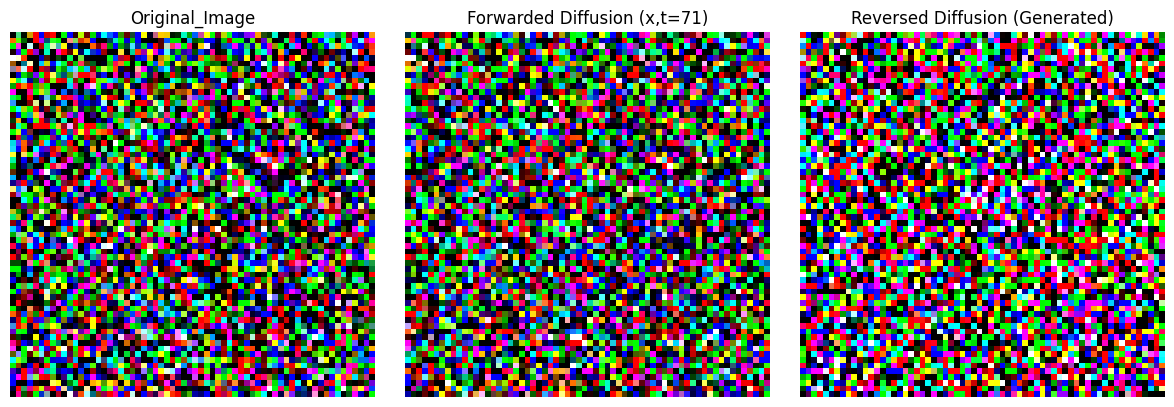

In [11]:
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


diffusion_model = Diffusion(in_channels=3, unet_output_channels=3).to(device)
scheduler = DiffusionScheduler(T=100, device=device)

# Taking Fake image (for demo)
x0 = torch.randn(1, 3, 64, 64, device=device)

# Forward diffusion example
t = torch.randint(0, scheduler.T, (1,), device=device)
xt, _ = forward_diffusion(x0, t, scheduler)

# Reverse diffusion (sampling)
generated_image = reverse_diffusion(
    diffusion_model,
    scheduler,
    shape=(1, 3, 64, 64),
    device=device
)
x0=torch.clamp(x0,0,1)
xt=torch.clamp(xt,0,1)
generated_image = torch.clamp(generated_image, 0, 1)

x0_np=x0[0].permute(1,2,0).cpu().detach().numpy()
xt_np=xt[0].permute(1,2,0).cpu().detach().numpy()
gen_np=generated_image[0].permute(1,2,0).cpu().detach().numpy()

fix, axes = plt.subplots(1,3 , figsize=(12,4))

axes[0].imshow(x0_np)
axes[0].axis('off')
axes[0].set_title('Original_Image')

axes[1].imshow(xt_np)
axes[1].axis('off')
axes[1].set_title(f'Forwarded Diffusion (x,t={t.item()})')

axes[2].imshow(gen_np)
axes[2].axis('off')
axes[2].set_title('Reversed Diffusion (Generated)')

plt.tight_layout()
plt.show()

In [12]:
from google.colab import files
from PIL import Image
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
uploaded = files.upload()

image_path = list(uploaded.keys())[0]

Saving German_Shepherd_-_DSC_0346_(10096362833).jpg to German_Shepherd_-_DSC_0346_(10096362833) (7).jpg


In [20]:
def multi_step_denoise(xt,noise,scheduler,t):
  x_current=xt.clone()

  for t_step in reversed(range(t.item()+1)):
    a_hat=scheduler.alpha_bar[t_step].view(-1,1,1,1)

    x_prev=(x_current-torch.sqrt(1-a_hat)*noise)/torch.sqrt(a_hat)
    x_current=x_prev

    x_denoised=torch.clamp(x_current,0,1)
    return x_denoised

In [13]:
from PIL import Image
from torchvision import transforms

img = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])
x0 = transform(img).unsqueeze(0).to(device)  # shape: [1,3,64,64]

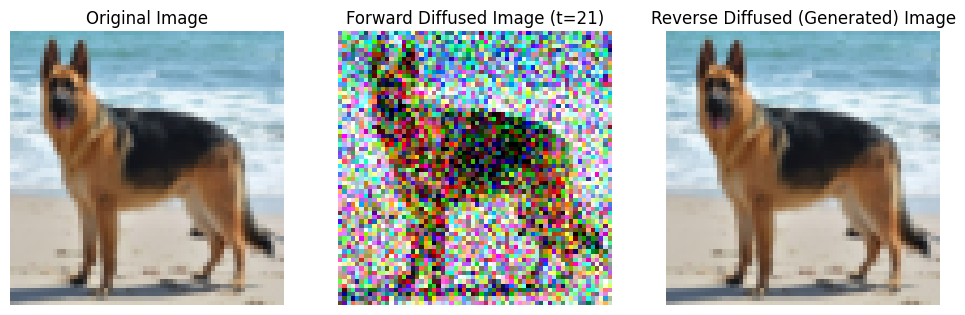

In [37]:
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

diffusion_model = Diffusion(in_channels=3, unet_output_channels=3).to(device)
scheduler = DiffusionScheduler(T=50, device=device)

# Forward diffusion example
t = torch.randint(0, scheduler.T, (1,), device=device)
xt, noise = forward_diffusion(x0, t, scheduler)

# Reverse diffusion (sampling)
x_denoised = multi_step_denoise(
    xt,
    noise,
    scheduler,
    t
)

x0_np = torch.clamp(x0, 0, 1)
xt_np=torch.clamp(xt,0,1)
x_denoised = torch.clamp(x_denoised, 0, 1)

x0_np = x0_np[0].permute(1, 2, 0).cpu().detach().numpy()
xt_np=xt_np[0].permute(1,2,0).cpu().detach().numpy()
img_np = x_denoised[0].permute(1, 2, 0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(x0_np)
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(xt_np)
axes[1].axis('off')
axes[1].set_title(f'Forward Diffused Image (t={t.item()})') # Corrected title

axes[2].imshow(img_np)
axes[2].axis('off')
axes[2].set_title('Reverse Diffused (Generated) Image') # Corrected title

plt.show()


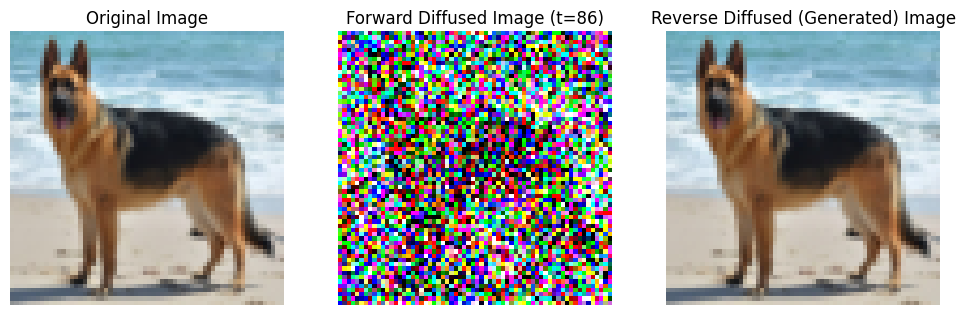

In [35]:
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

diffusion_model = Diffusion(in_channels=3, unet_output_channels=3).to(device)
scheduler = DiffusionScheduler(T=100, device=device)

# Forward diffusion example
t = torch.randint(0, scheduler.T, (1,), device=device)
xt, noise = forward_diffusion(x0, t, scheduler)

# Reverse diffusion (sampling)
x_denoised = multi_step_denoise(
    xt,
    noise,
    scheduler,
    t
)

x0_np = torch.clamp(x0, 0, 1)
xt_np=torch.clamp(xt,0,1)
x_denoised = torch.clamp(x_denoised, 0, 1)

x0_np = x0_np[0].permute(1, 2, 0).cpu().detach().numpy()
xt_np=xt_np[0].permute(1,2,0).cpu().detach().numpy()
img_np = x_denoised[0].permute(1, 2, 0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(x0_np)
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(xt_np)
axes[1].axis('off')
axes[1].set_title(f'Forward Diffused Image (t={t.item()})') # Corrected title

axes[2].imshow(img_np)
axes[2].axis('off')
axes[2].set_title('Reverse Diffused (Generated) Image') # Corrected title

plt.show()
